# Unpickle X & Y; Train-Validation Split

In [107]:
from sklearn.model_selection import train_test_split
import pickle

X_combined, y_combined = pickle.load(open('Xy_combined_congestion.pkl', 'rb'))

In [108]:
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.05, random_state=42)
X_train_combined, X_va_combined, y_train_combined, y_va_combined = train_test_split(X_train_combined, y_train_combined, test_size=0.05, random_state=42)

# Baseline without Sequential Inputs

In [109]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
# get the baseline mae again
model_combined = LinearRegression()
model_combined.fit(X_train_combined, y_train_combined)
y_pred_combined = model_combined.predict(X_test_combined)
mae_combined = mean_absolute_error(y_test_combined, y_pred_combined)
print(f"Baseline MAE with route features: {mae_combined:.2f} seconds")

Baseline MAE with route features: 216.23 seconds


In [110]:
from xgboost import XGBRegressor
# Train XGBoost model with route features
xgb_model_combined = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb_model_combined.fit(X_train_combined, y_train_combined)
y_pred_combined = xgb_model_combined.predict(X_test_combined)
print("XGBoost with Route Features MAE:", mean_absolute_error(y_test_combined, y_pred_combined))

XGBoost with Route Features MAE: 202.9619796252945


# Transformer - Preprocess

In [111]:
import torch

padded_routes = pickle.load(open('padded_routes.pkl', 'rb'))
encoded_routes = pickle.load(open('encoded_routes.pkl', 'rb'))
attention_mask = torch.tensor([
    [0]+ [1]*len(r) + [0]*(padded_routes.shape[1] - len(r)) for r in encoded_routes
])  # (B, L+1) due to the added start token

In [112]:
len(padded_routes)

16470

In [113]:
import numpy as np
# Sequence input: (B, N, 2) where B=batch, N=#points, 2=(lat, lon)
seq_input = torch.tensor(padded_routes, dtype=torch.float32)  # shape: (B, N, 2)

print(f"Scalars used: {len(X_combined.columns)}")# Scalar input: (B, F)
scalar_input = torch.tensor(X_combined.values, dtype=torch.float32)  # shape: (B, F)

# Output: ETA in seconds
eta_target = torch.tensor(y_combined, dtype=torch.float32)  # shape: (B,)


Scalars used: 22


In [114]:
#take 5% of seq,scalar, and eta for validation
seq_input, seq_test, scalar_input, scalar_test, eta_target, eta_test, attention_mask, attention_mask_test = train_test_split(
    seq_input, scalar_input, eta_target, attention_mask, test_size=0.05, random_state=42)
seq_input, seq_va, scalar_input, scalar_va, eta_target, eta_va, attention_mask, attention_mask_va = train_test_split(
    seq_input, scalar_input, eta_target, attention_mask, test_size=0.05, random_state=42)

In [115]:
seq_input.shape, scalar_input.shape, eta_target.shape, attention_mask.shape

(torch.Size([14863, 114, 2]),
 torch.Size([14863, 22]),
 torch.Size([14863]),
 torch.Size([14863, 115]))

# Transformer - Define

In [ ]:
import torch
import torch.nn as nn

class ETA_Transformer(nn.Module):
    def __init__(self, seq_dim=2, scalar_dim=22, d_model=256, nhead=8, num_layers=3):
        super().__init__()
        self.input_proj = nn.Linear(seq_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(500, d_model))  # max 500 points
        
        encoder_layer = nn.TransformerEncoderLayer(dim_feedforward=1024,d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.scalar_proj = nn.Linear(scalar_dim, d_model)
        self.output_head = nn.Sequential(
            nn.Linear(d_model * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
            # nn.ReLU(),
            # nn.Linear(16, 1)  # Final output for ETA prediction
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))


    def forward(self, route_seq, scalar_feats, attention_mask):
        """
        route_seq: (B, N, 2)
        scalar_feats: (B, F)
        """
        B, N, _ = route_seq.size()
        x = self.input_proj(route_seq)  # (B, N, d_model)

        
        cls_tokens = self.cls_token.expand(B, 1, -1)  # (B, 1, d_model)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, N+1, d_model)

        x = x + self.pos_encoding[:N+1]  # add positional encoding, N+1 because of [CLS] token

        x = self.transformer(x, src_key_padding_mask=(attention_mask == 0))  # (B, N, d_model)
        route_embedding = x[:, 0, :]  # [CLS] token output
        
        mask = attention_mask.unsqueeze(-1)  # (B, L, 1)
        masked_x = x * mask  # zero out padding
        route_embedding = masked_x.sum(1) / mask.sum(1)  # (B, d_model)
        #route_embedding = x.mean(dim=1)  # (B, d_model)

        scalar_embedding = self.scalar_proj(scalar_feats)  # (B, d_model)
        combined = torch.cat([route_embedding, scalar_embedding], dim=1)  # (B, 2*d_model)

        eta_pred = self.output_head(combined).squeeze(-1)  # (B,)
        return eta_pred


In [ ]:
model = ETA_Transformer()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
loss_fn = nn.L1Loss()
epochs = 28

In [118]:
for epoch in range(epochs):
    model.train()
    #sample a 5% batch
    batch_size = int(0.05 * seq_input.shape[0])
    indices = torch.randperm(seq_input.shape[0])[:batch_size]
    seq_input_batch = seq_input[indices]
    scalar_input_batch = scalar_input[indices]
    eta_target_batch = eta_target[indices]
    attention_mask_batch = attention_mask[indices]

    pred = model(seq_input_batch, scalar_input_batch,attention_mask_batch)
    loss = loss_fn(pred, eta_target_batch)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.2f}")
    # print validation loss
    with torch.no_grad():
        model.eval()
        pred_test = model(seq_test, scalar_test, attention_mask_test)
        test_loss = loss_fn(pred_test, eta_test)
        print(f"Validation Loss: {test_loss.item():.2f}")


Epoch 1, Loss: 686.68
Validation Loss: 634.93
Epoch 2, Loss: 610.35
Validation Loss: 576.81
Epoch 3, Loss: 553.53
Validation Loss: 520.57
Epoch 4, Loss: 521.56
Validation Loss: 466.88
Epoch 5, Loss: 449.62
Validation Loss: 417.63
Epoch 6, Loss: 424.35
Validation Loss: 373.31
Epoch 7, Loss: 359.54
Validation Loss: 335.36
Epoch 8, Loss: 323.39
Validation Loss: 302.67
Epoch 9, Loss: 300.79
Validation Loss: 279.39
Epoch 10, Loss: 258.12
Validation Loss: 265.76
Epoch 11, Loss: 263.35
Validation Loss: 260.80
Epoch 12, Loss: 249.22
Validation Loss: 260.59
Epoch 13, Loss: 264.06
Validation Loss: 263.72
Epoch 14, Loss: 245.53
Validation Loss: 269.10
Epoch 15, Loss: 260.78
Validation Loss: 274.09
Epoch 16, Loss: 248.69
Validation Loss: 277.78
Epoch 17, Loss: 272.35
Validation Loss: 279.48
Epoch 18, Loss: 263.87
Validation Loss: 278.68
Epoch 19, Loss: 264.18
Validation Loss: 276.22
Epoch 20, Loss: 249.01
Validation Loss: 272.37
Epoch 21, Loss: 261.41
Validation Loss: 267.21
Epoch 22, Loss: 253.80

In [119]:
# save the model
import pickle
pickle.dump(model,open('trained_transformer_congestion.pkl', 'wb'))

In [165]:
# get the predictions on the training set for the congestion model
with torch.no_grad():
    train_pred = model(seq_input, scalar_input, attention_mask)
    test_pred = model(seq_test, scalar_test, attention_mask_test)

In [186]:
# train an MLP with X=train_pred & scalar_input; Y=eta_target-train_pred
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(-1)  # (B,)

mlp_model = MLP(input_dim=1+ scalar_input.shape[1])
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)
loss_fn_mlp = nn.L1Loss()

In [187]:
epochs = 50
for epoch in range(epochs):
    mlp_model.train()
    #sample a 5% batch
    batch_size = int(0.05 * train_pred.shape[0])
    indices = torch.randperm(train_pred.shape[0])[:batch_size]
    train_pred_batch = train_pred[indices].unsqueeze(1)  # shape (B, 1)
    scalar_input_batch = scalar_input[indices]
    eta_target_batch = eta_target[indices]
    input_batch = torch.cat([train_pred_batch, scalar_input_batch], dim=1)  # (B, 1+F)

    pred_mlp = mlp_model(input_batch)
    loss_mlp = loss_fn_mlp(pred_mlp, eta_target_batch)
    optimizer_mlp.zero_grad()
    loss_mlp.backward()
    optimizer_mlp.step()
    print(f"Epoch {epoch+1}, MLP Loss: {loss_mlp.item():.2f}")

    # validation loss
    with torch.no_grad():
        mlp_model.eval()
        input_va = torch.cat([test_pred.unsqueeze(1), scalar_test], dim=1)
        pred_va = mlp_model(input_va)
        va_loss = loss_fn_mlp(pred_va, eta_test)
        print(f"Validation Loss: {va_loss.item():.2f}")


Epoch 1, MLP Loss: 722.50
Validation Loss: 662.71
Epoch 2, MLP Loss: 635.92
Validation Loss: 610.84
Epoch 3, MLP Loss: 605.90
Validation Loss: 559.02
Epoch 4, MLP Loss: 563.89
Validation Loss: 507.47
Epoch 5, MLP Loss: 473.56
Validation Loss: 457.12
Epoch 6, MLP Loss: 431.17
Validation Loss: 408.39
Epoch 7, MLP Loss: 394.48
Validation Loss: 361.76
Epoch 8, MLP Loss: 338.29
Validation Loss: 319.13
Epoch 9, MLP Loss: 314.71
Validation Loss: 283.51
Epoch 10, MLP Loss: 262.59
Validation Loss: 258.51
Epoch 11, MLP Loss: 249.94
Validation Loss: 243.65
Epoch 12, MLP Loss: 242.18
Validation Loss: 236.03
Epoch 13, MLP Loss: 219.05
Validation Loss: 235.71
Epoch 14, MLP Loss: 232.89
Validation Loss: 240.35
Epoch 15, MLP Loss: 225.13
Validation Loss: 247.84
Epoch 16, MLP Loss: 237.45
Validation Loss: 255.79
Epoch 17, MLP Loss: 250.66
Validation Loss: 263.31
Epoch 18, MLP Loss: 256.93
Validation Loss: 269.31
Epoch 19, MLP Loss: 257.93
Validation Loss: 273.48
Epoch 20, MLP Loss: 264.35
Validation Lo

# Performance eval

In [188]:
#model = pickle.load(open('trained_transformer_congestion.pkl', 'rb'))

In [189]:
with torch.no_grad():
    model.eval()
    pred_va = model(seq_va, scalar_va, attention_mask_va)
    va_loss = loss_fn(pred_va, eta_va)
    print(f"Test Loss: {va_loss.item():.2f}")

Test Loss: 226.26


In [190]:
#with the mlp boosting the congestion model
with torch.no_grad():
    pred_va_mlp = mlp_model(torch.cat([pred_va.unsqueeze(1), scalar_va], dim=1))
    va_loss_mlp = loss_fn_mlp(pred_va_mlp, eta_va)
    print(f"Test Loss with MLP: {va_loss_mlp.item():.2f}")

Test Loss with MLP: 221.40


In [191]:
model2=pickle.load(open('trained_transformer.pkl', 'rb'))

In [192]:
with torch.no_grad():
    model2.eval()
    pred_va_2 = model2(seq_va, scalar_va, attention_mask_va)
    va_loss_2 = loss_fn(pred_va_2, eta_va)
    print(f"Test Loss: {va_loss_2.item():.2f}")

Test Loss: 230.25


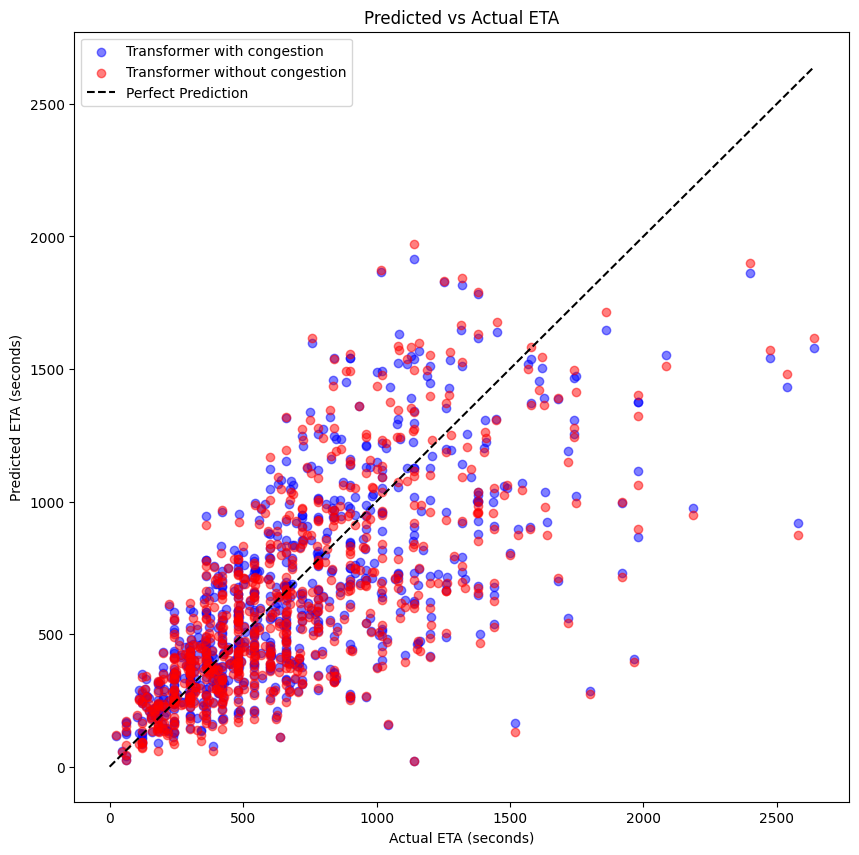

In [193]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(eta_va.numpy(), pred_va.numpy(), alpha=0.5, label='Transformer with congestion', color='blue')
plt.scatter(eta_va.numpy(), pred_va_2.numpy(), alpha=0.5, label='Transformer without congestion', color='red')
plt.plot([0, max(eta_va)], [0, max(eta_va)], color='black', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual ETA (seconds)')
plt.ylabel('Predicted ETA (seconds)')
plt.title('Predicted vs Actual ETA')
plt.legend()
plt.show()


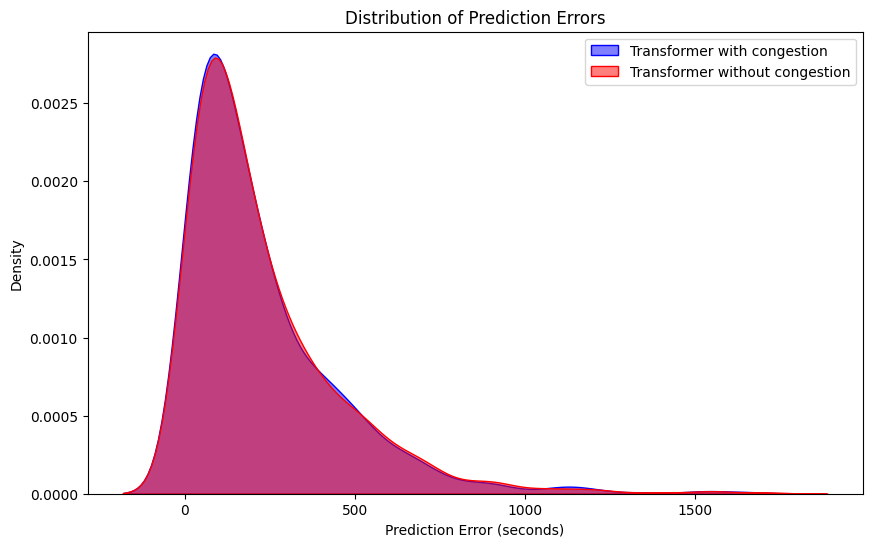

In [194]:
# show overlaid distribution of errors
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.kdeplot(abs(eta_va.numpy() - pred_va.numpy()), label='Transformer with congestion', color='blue', fill=True, alpha=0.5)
sns.kdeplot(abs(eta_va.numpy() - pred_va_2.numpy()), label='Transformer without congestion', color='red', fill=True, alpha=0.5)
plt.xlabel('Prediction Error (seconds)')
plt.ylabel('Density')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.show()


In [196]:
# do a statistical test to compare the two models
from scipy.stats import ttest_rel
errors_with_congestion = abs(eta_va.numpy() - pred_va.numpy())
errors_without_congestion = abs(eta_va.numpy() - pred_va_2.numpy())
t_stat, p_value = ttest_rel(errors_with_congestion, errors_without_congestion)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")

T-statistic: -4.57, P-value: 0.0000
